Importação das bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

**1 -) Leitura e armazendo individual dos arquivos .json**



In [36]:
dados1 = pd.read_json('dadoslote1.json')
dados2 = pd.read_json('dadoslote2.json')
dados3 = pd.read_json('dadoslote3.json')
dados4 = pd.read_json('dadoslote4.json')

Foi verificado que os dataframes tem semelhantes colunas, porém, nomes diferentes, foram renomeadas e concatenas. 



In [37]:
df13 = pd.concat([dados1,dados3])
df24 = pd.concat([dados2,dados4])

In [38]:
df24 = df24.rename(columns = {'cod_animal': 'idanimal', 'nro_lote': 'idlote', 'pesagens': 'peso' ,'dia': 'data'}, inplace = False)

In [5]:
df24.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15195 entries, 0 to 7619
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idanimal  15195 non-null  int64  
 1   idlote    15195 non-null  int64  
 2   peso      15195 non-null  float64
 3   data      15195 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 593.6+ KB


In [6]:
df13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15240 entries, 0 to 7619
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idanimal  15240 non-null  int64  
 1   idlote    15240 non-null  int64  
 2   peso      15240 non-null  float64
 3   data      15240 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 595.3+ KB


In [39]:
df = pd.concat([df13,df24],ignore_index=True)

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30435 entries, 0 to 30434
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idanimal  30435 non-null  int64  
 1   idlote    30435 non-null  int64  
 2   peso      30435 non-null  float64
 3   data      30435 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 951.2+ KB


**2 -) Verificação de animais duplicados nos lotes**

In [9]:
df['idlote'].value_counts()

1    7620
3    7620
4    7620
2    7575
Name: idlote, dtype: int64

In [10]:
dfDuplicate = df.groupby(['idanimal','idlote']).mean().reset_index()
#fDuplicate = pd.DataFrame(dfDuplicate)


In [11]:
dfDuplicate[dfDuplicate['idanimal'].duplicated()].count()

idanimal    0
idlote      0
peso        0
dtype: int64

In [ ]:
dfDuplicate

Foi usado o merge, porém sem muito sucesso, pois, ele pega apenas 2 colunas por vez, ou seja, teriamos que fazer as combinações. Usando um repetidor.


In [ ]:
groups = df.groupby(df.idlote)
qtd = (pd.merge(groups.get_group(1),groups.get_group(2),on=['idanimal'] ,how='inner',indicator=True)).count()
 
qtd[('idanimal')]

**3 -) Agrupamos por data e lote, e usamos como medida de tendência central a média, para obtermos o peso.**

In [14]:
df2 = df.groupby(['data','idlote']).mean().reset_index()
#df2.groupby('idlote').agg({'peso': ['mean'],'data': ['max'],'idlote': ['first']}).reset_index() Caso tivesse colunas alem de peso...

OBS: Não foi simplificada a escala da datas neste primeiro plot, e os valores de x ficaram todos "grudados".

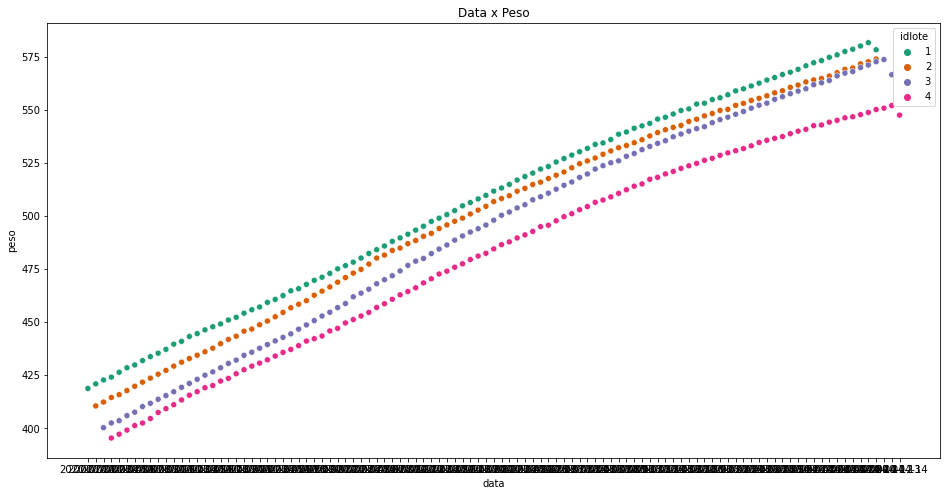

In [15]:
plt.figure(figsize=(16,8))
plt.title('Data x Peso')
sns.scatterplot(x='data', y='peso',data=df2,hue='idlote',palette='Dark2')
plt.show()

Vamos aplicar uma escala maior pra corrigir isto


In [16]:
df['data'] =  pd.to_datetime(df['data']).dt.strftime('%y/%m') 
df2 = df.groupby(['data','idlote']).mean().reset_index()

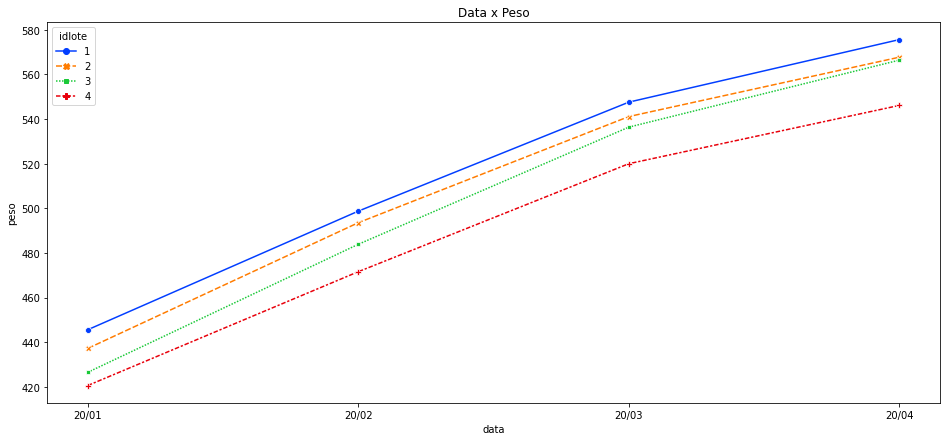

In [17]:
plt.figure(figsize=(16,7))
plt.title('Data x Peso')
sns.lineplot(x='data', y='peso',data=df2,hue='idlote',palette='bright',style='idlote',markers=True)
plt.show()

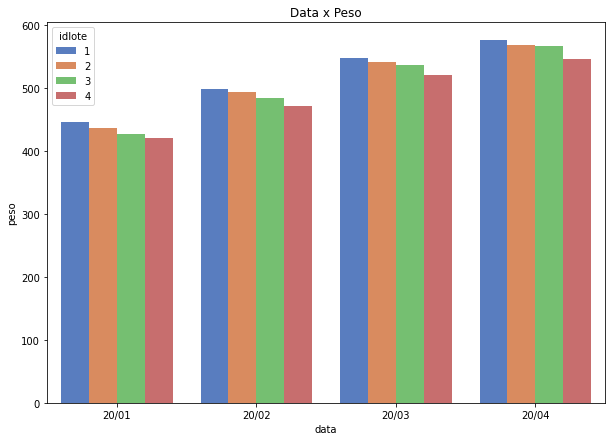

In [18]:
plt.figure(figsize=(10,7))
plt.title('Data x Peso')
sns.barplot(x='data', y='peso',data=df2,hue='idlote',palette='muted')
plt.show()

**4-) Informações de estatítica descritiva agrupada por lotes**

In [19]:
df.groupby(['idlote']).describe().T

idlote                    1            2            3            4
idanimal count  7620.000000  7575.000000  7620.000000  7620.000000
         mean    638.312992   691.400000   720.805118   765.001969
         std      26.079322     5.314483    16.387508     9.957548
         min     608.000000   683.000000   700.000000   756.000000
         25%     610.000000   689.000000   709.000000   757.000000
         50%     645.000000   691.000000   715.000000   761.000000
         75%     653.000000   696.000000   739.000000   768.000000
         max     676.000000   698.000000   741.000000   783.000000
peso     count  7620.000000  7575.000000  7620.000000  7620.000000
         mean    505.412990   499.468012   493.732321   482.259597
         std      50.910576    50.678049    54.350250    53.200572
         min     400.468700   397.839300   383.913000   374.108200
         25%     460.813775   455.666200   446.303975   438.844575
         50%     507.007850   502.754100   496.604550   481.498650
         75%     548.052075   540.081500   537.399775   520.282050
         max     605.741800   606.517800   611.901300   601.999900

5-) Representando a quantidade de pesagem por dia. Para isso precisamos resetar o DataFrame para pegarmos todos os valores sem agrupamento,registraremos a pesagem para alguns dias, pois, são muitos valores, ou teriamos que dividir o DataFrame e mesmo assim ficaria grande a plotagem.



In [20]:
df = pd.concat([df13,df24],ignore_index=True)
df = df.sort_values(by=['data']) #classifica o DataFrame pelo rótulo data.

#result = df.groupby('idlote').agg({'peso': ['mean'],'data': ['max'],'idlote': ['first']}).reset_index()

In [21]:
df['data'].value_counts()

2020-02-22    300
2020-03-06    300
2020-03-16    300
2020-03-15    300
2020-03-14    300
             ... 
2020-04-12    150
2020-01-02    150
2020-04-13    120
2020-01-01     75
2020-04-14     45
Name: data, Length: 105, dtype: int64

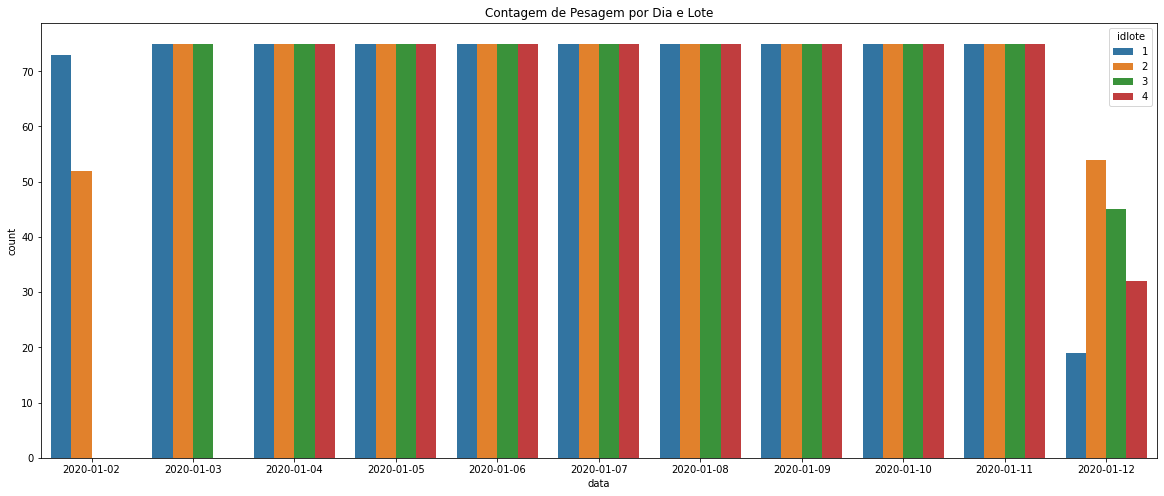

In [22]:
plt.figure(figsize=(20,8))
plt.title('Contagem de Pesagem por Dia e Lote')
sns.countplot(x='data',hue='idlote',data=df[100:3000])

Somando as 4 colunas ele chega ao total geral do dia.ex: 4*75 = 300. 

Foram escolhidos dados aleatório para exibir, pois, são muitos dias.


**6 - ) Ajustando a curva para o ganho de peso de cada animal**


Procuramos um padrão de forma geral, e não por amostrar, se preferir pule esta estapa para dados únicos... (a modalagem é melhor por amostra unicas)

In [23]:
df2 = df.groupby(['data','idanimal']).mean().reset_index()

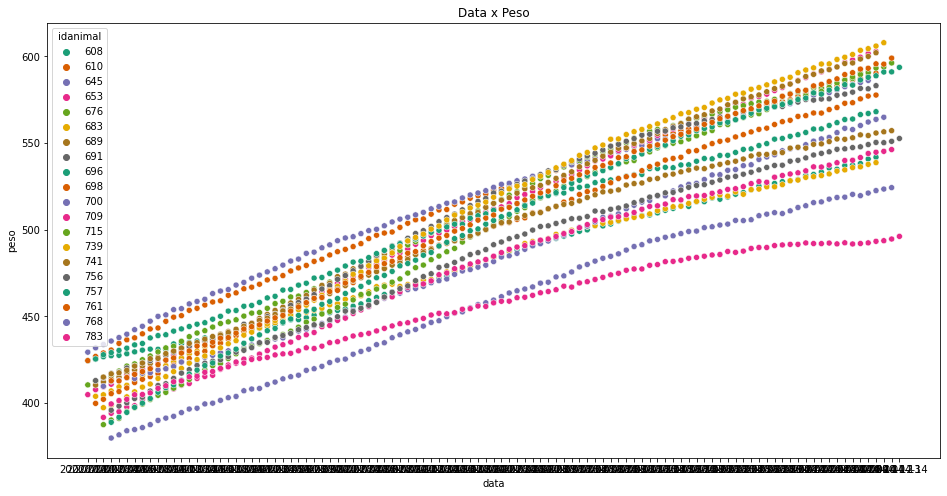

In [24]:
plt.figure(figsize=(16,8))
plt.title('Data x Peso')
sns.scatterplot(x='data', y='peso',data=df2,hue='idanimal',palette='Dark2')
plt.show()

In [25]:
df = pd.concat([df13,df24],ignore_index=True)

In [26]:
df['data'] = pd.to_datetime(df['data'])
df['data']=df['data'].map(dt.datetime.toordinal)

In [27]:
df = df.drop(columns=['idlote']) #Removi lote, pois, não há animais no mesmo lote.
df = df.dropna(axis=0, how='any')
df2 = df.groupby(['idanimal','data']).mean().reset_index()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('peso', axis=1), df2['peso'],test_size=0.3) 

In [29]:
lm = LinearRegression() 

In [30]:
lm.fit(X_train,y_train) 

LinearRegression()

In [31]:
predict = lm.predict(X_test)
 

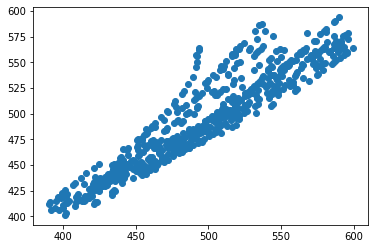

In [32]:
plt.scatter(y_test,predict) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


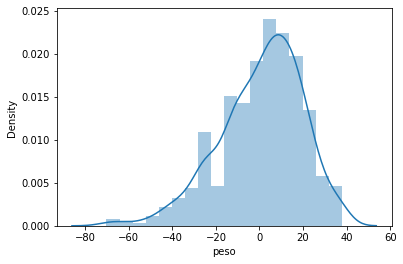

In [33]:
sns.distplot(y_test-predict) 

Agora pegando um dos animais especificos e trabalhando sobre ele

In [34]:
def PredicAnimal(animals,daySum=0,periodo=''):

  if (periodo != '') :
    format = '%Y/%m/%d'
    VarToDate = dt.datetime.strptime(periodo, format)
    toOrdinal = VarToDate.toordinal()
  
  for x in animals:
    df2_mask=df['idanimal']== x #Boleano
    df2 = df[df2_mask] #Transforma em valor.
    df2 = df2.groupby(['data']).mean().reset_index()

    if (daySum > 0) :
      lastDate = df2.at[df2.index[-1],'data'] + daySum
    else:
      lastDate = toOrdinal

    X_train, X_test, y_train, y_test = train_test_split(df2.drop('peso', axis=1), df2['peso'],test_size=0.3)
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predict = lm.predict(X_test)
    
    dia_teste = [(lastDate,x)] 
    dia_predito = lm.predict(dia_teste)

    format = '%Y/%m/%d'
    VarToDate = dt.date.fromordinal(lastDate)

    #plt.scatter(y_test,predict) 
    plt.figure(figsize=(12,5))
    plt.title('Data x Peso')
    sns.scatterplot(x='data', y='peso',data=df2,hue='idanimal',palette='Dark2')
    plt.show()
    print('O peso do animal {},no dia {}, será de: {}'.format(x,VarToDate,dia_predito))
    print('')

Poderia ter colocado uma estrutura de repetição ("For") para ir trocando os valores dos animais, questão de capricho e tempo.

In [ ]:
Animals = df['idanimal'].unique()
Animals

In [ ]:
PredicAnimal(Animals,0,'2020/02/06')

In [ ]:
PredicAnimal([700],15)

In [ ]:
PredicAnimal(Animals,15)

In [ ]:
#df2[df2['idanimal']==700] #Para ver o ultimo dia(ComparAR resultados).

Código abaixo apenas para validações...

In [ ]:
df2_mask=df['idanimal']== 700 #Boleano
df2 = df[df2_mask] #Transforma em valor.
df2 = df2.groupby(['data']).mean().reset_index()

**NOVAS IMPLEMENTAÇÕES 13/04/2022** - Usei o modelo o modelo SVR para treinar a base de dados, consegui resultados melhores e mais precisos, pois, a curva se adequou aos dados, esperavamos um curva parecida com a de função logarítmica e não linear, claro, em alguns casos se pareceu bastante com a linear, pois, se adequou a plotagem.

**Para fins de limpeza e dados confiaveis, siga os passo abaixo:**

1.   Aconselho rodar novamente a parte do exercicio 1
2.   Rodar código abaixo
3.   Verifique se as bibliotecas estão compildas... 

In [40]:
df = pd.concat([df13,df24],ignore_index=True)
df['data'] = pd.to_datetime(df['data'])
df['data']=df['data'].map(dt.datetime.toordinal)
df = df.drop(columns=['idlote']) #Removi lote, pois, não há animais no mesmo lote.
df = df.dropna(axis=0, how='any')
df2 = df.groupby(['idanimal','data']).mean().reset_index()

In [41]:
def PredicAnimalSVR(animals,daySum=0,periodo=''):

  if (periodo != '') :
    format = '%Y/%m/%d'
    VarToDate = dt.datetime.strptime(periodo, format)
    toOrdinal = VarToDate.toordinal()
  
  for x in animals:
    df2_mask=df['idanimal']== x #Boleano
    df2 = df[df2_mask] #Transforma em valor.
    df2 = df2.groupby(['data']).mean().reset_index()

    if (daySum > 0) :
      lastDate = df2.at[df2.index[-1],'data'] + daySum
    else:
      lastDate = toOrdinal

    ###
    from sklearn.metrics import r2_score
    X_train, X_test, y_train, y_test = train_test_split(df2['data'], df2['peso'], test_size = 0.3, random_state = 101)

    regressor_SVR = SVR(C = 300)
    regressor_SVR.fit(np.array(X_train).reshape(-1, 1), y_train)

    predict_SVR = regressor_SVR.predict(np.array(X_test).reshape(-1, 1))
    r2_score_test = r2_score(y_test, predict_SVR)

    predict_SVR = regressor_SVR.predict(np.array(df2['data']).reshape(-1, 1))
    r2_score = r2_score(df2['peso'], predict_SVR)

    dia_teste = [(lastDate)] 
    dia_predito = regressor_SVR.predict((np.array(dia_teste)).reshape(-1, 1))

    format = '%Y/%m/%d'
    VarToDate = dt.date.fromordinal(lastDate)
    ##
    plt.figure(figsize=(10,5))
    plt.plot(df2['data'], df2['peso'], '--', label="Original Noised Data",linewidth=4.0)
    plt.plot(df2['data'], predict_SVR, 'r-', label="Fitted Curve",linewidth=3.0,alpha=0.7)
    plt.xlabel('Tempo')
    plt.ylabel('Peso')
    plt.legend(loc='best')
    plt.show()

    print('O peso do animal {},no dia {}, será de: {}, Precisão de acerto: {}'.format(x,VarToDate,dia_predito,r2_score))
    print('')

O Código abaixo atribui todos os animais em uma lista 

In [42]:
Animals = df['idanimal'].unique()

Descomente uma das 3 linhas abaixo para testa-la (Importante ser uma de cada vez para visualizar os resultados)

***OS TESTES ABAIXO PODEM SER FEITOS COMO DESEJAR, APENAS DEIXEI ALGUNS EXEMPLOS***

1.   A Primeira linha traz todos os animais daqui 15 dias após seu ultimo registro(pode escolher o dia que preferir incrementar)
2.   A Segunda linha traz um Id de um animal que quiser e soma quantos dias quiser
3.   A Terceira linha traz todos os animais, sem incrementar, e no dia escolhido



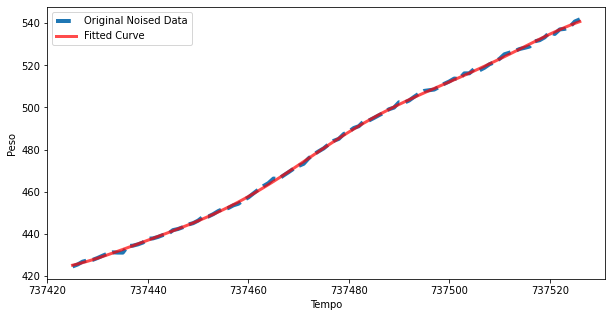

O peso do animal 608,no dia 2020-04-26, será de: [541.39593001], Precisão de acerto: 0.999763813772423



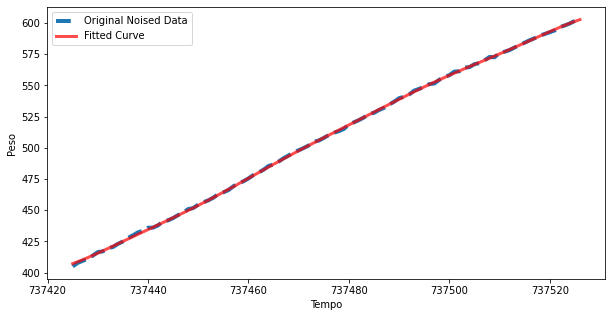

O peso do animal 653,no dia 2020-04-26, será de: [603.11695994], Precisão de acerto: 0.999888024739301



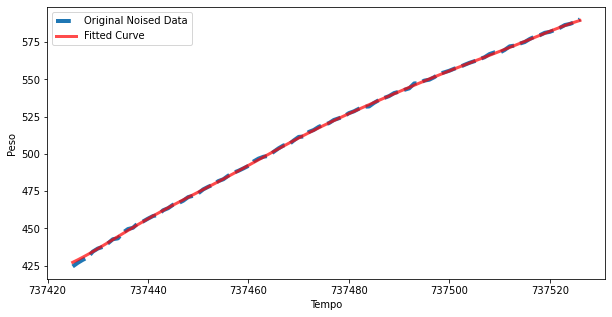

O peso do animal 610,no dia 2020-04-26, será de: [590.20951377], Precisão de acerto: 0.9998148319113821



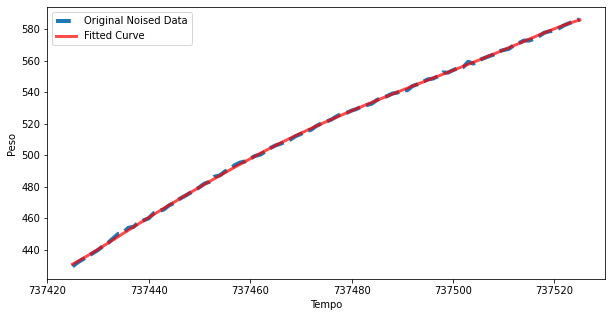

O peso do animal 645,no dia 2020-04-25, será de: [586.60848692], Precisão de acerto: 0.999815124863823



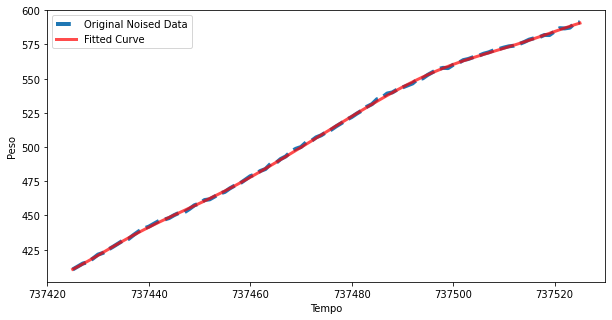

O peso do animal 676,no dia 2020-04-25, será de: [592.65883179], Precisão de acerto: 0.9998778863043188



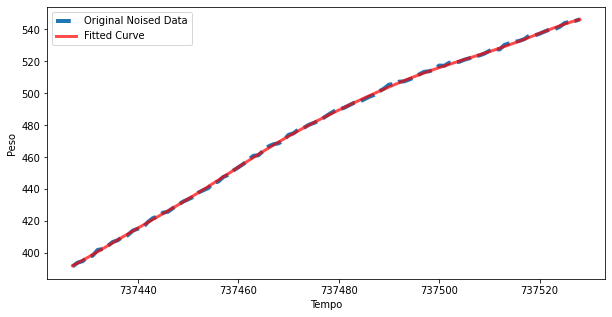

O peso do animal 709,no dia 2020-04-28, será de: [542.95405092], Precisão de acerto: 0.9998374850210349



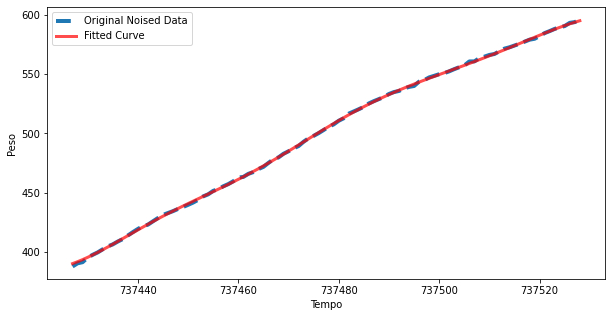

O peso do animal 715,no dia 2020-04-28, será de: [594.93349904], Precisão de acerto: 0.999878250741448



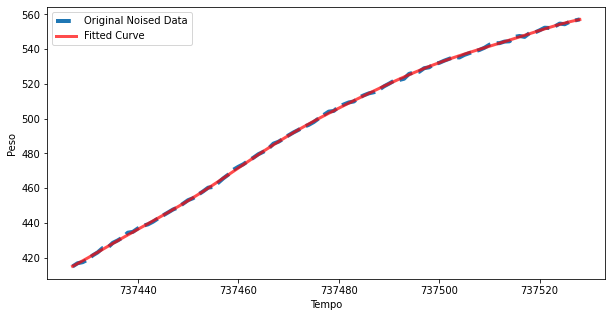

O peso do animal 741,no dia 2020-04-28, será de: [552.11084158], Precisão de acerto: 0.9998686098624057



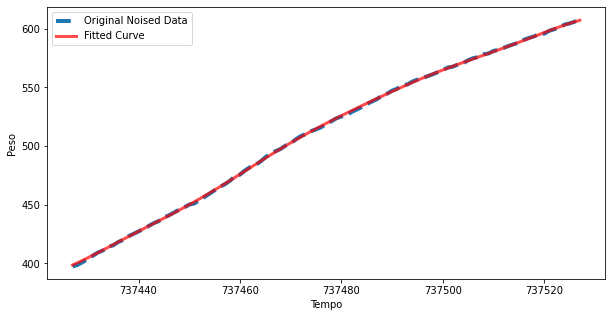

O peso do animal 739,no dia 2020-04-27, será de: [605.56238688], Precisão de acerto: 0.9998908082316176



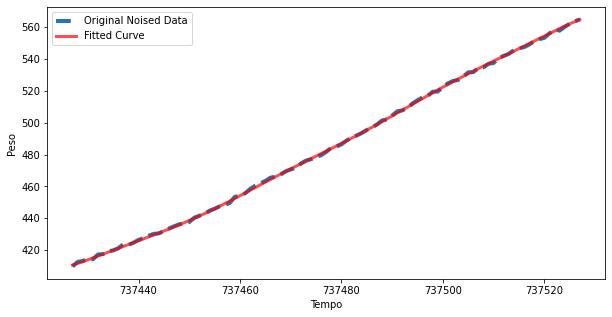

O peso do animal 700,no dia 2020-04-27, será de: [569.85925882], Precisão de acerto: 0.9998301074772343



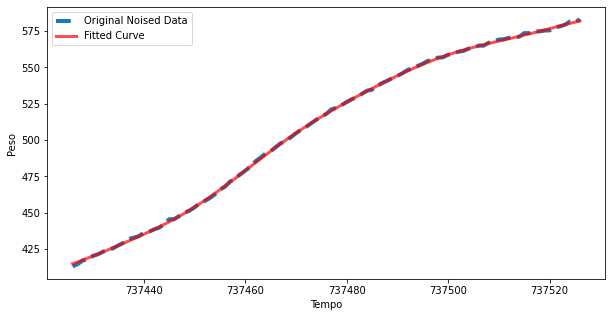

O peso do animal 691,no dia 2020-04-26, será de: [582.51012927], Precisão de acerto: 0.9998777917707691



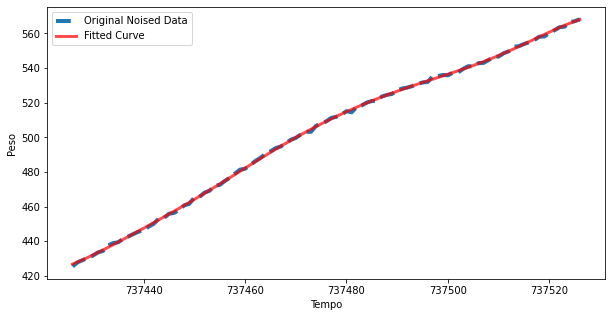

O peso do animal 696,no dia 2020-04-26, será de: [567.6070433], Precisão de acerto: 0.9997924315787254



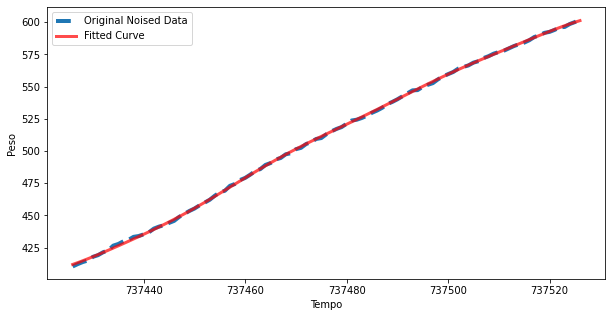

O peso do animal 689,no dia 2020-04-26, será de: [601.39879326], Precisão de acerto: 0.9998617980665283



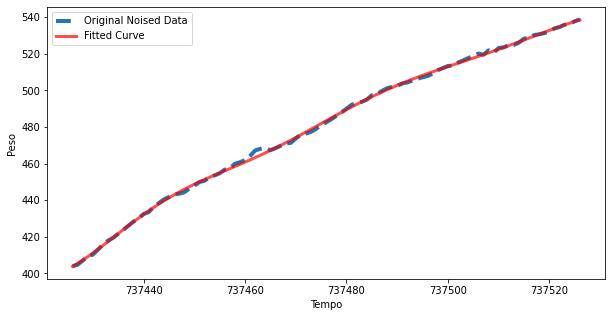

O peso do animal 683,no dia 2020-04-26, será de: [540.4099832], Precisão de acerto: 0.9994359342919958



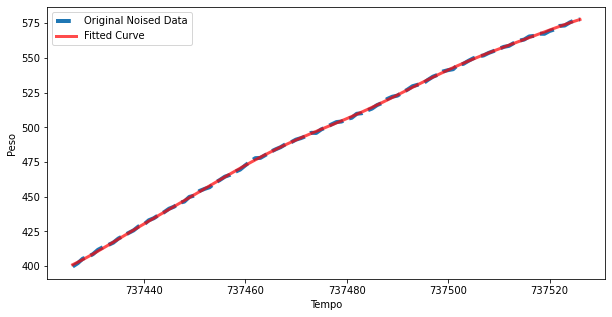

O peso do animal 698,no dia 2020-04-26, será de: [580.33412376], Precisão de acerto: 0.9998908537839132



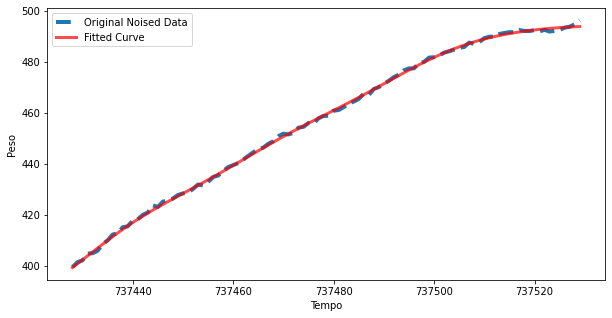

O peso do animal 783,no dia 2020-04-29, será de: [490.41415414], Precisão de acerto: 0.9994958265609017



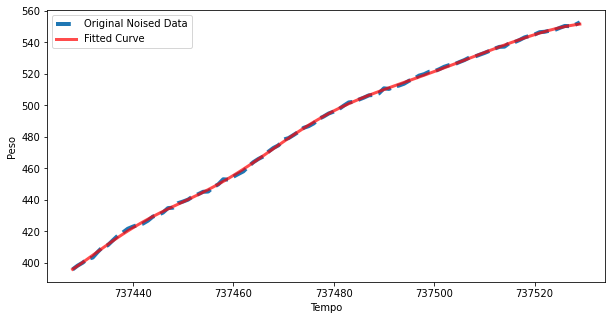

O peso do animal 756,no dia 2020-04-29, será de: [544.12232977], Precisão de acerto: 0.9998266177901687



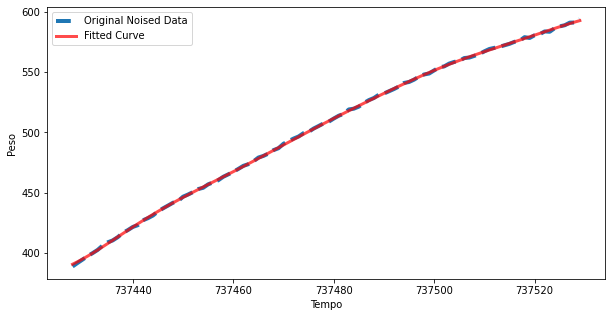

O peso do animal 757,no dia 2020-04-29, será de: [594.11621302], Precisão de acerto: 0.9999077650083026



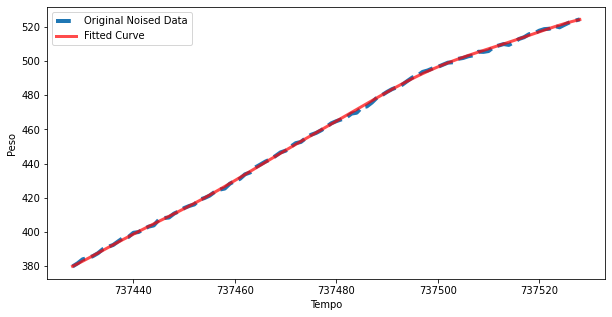

O peso do animal 768,no dia 2020-04-28, será de: [519.76014284], Precisão de acerto: 0.9998157000124381



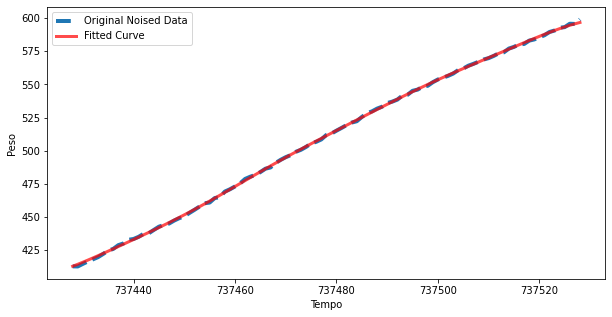

O peso do animal 761,no dia 2020-04-28, será de: [592.84012732], Precisão de acerto: 0.9998605098103662



In [43]:
PredicAnimalSVR(Animals,15)
#PredicAnimalSVR([700],20)
#PredicAnimalSVR(Animals,0,'2020/02/06')

Conclusões: Podemos perceber que a precisão de acerto é quase 100% (a precisão é alta pois a quantidade de fatores analisados foram simples e poucos, apenas 2 colunas). Percebemos que dependendo da curva do animal alguns começam até mesmo perder peso com o tempo.